# Stellar rotational broadening and RV shifting

The emergent spectrum of a star gets modulated by at least two *extrinsic* parameters---$v\sin{i}$ and $RV$---before entering our metaphorical orbit.  Here we show how to modulate a cloned stellar model with these two parameters.

In [1]:
import torch
from blase.emulator import SparseLinearEmulator, SparseLogEmulator, ExtrinsicModel
from blase.utils import doppler_grid
import matplotlib.pyplot as plt
import math
%config InlineBackend.figure_format='retina'

In [2]:
wl_lo = 11_000-60
wl_hi = 11_180+60
wavelength_grid = doppler_grid(wl_lo, wl_hi)

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

We will fetch the pretrained stellar model, following the previous tutorial.

In [4]:
stellar_pretrained_model = torch.load('phoenix_clone_T4700g4p5_prom0p01_11000Ang.pt')

In [5]:
stellar_emulator = SparseLinearEmulator(wavelength_grid, 
                                        init_state_dict=stellar_pretrained_model)

Initializing a sparse model with 426 spectral lines


In [6]:
y0 = stellar_emulator.forward().detach().cpu().numpy()

### Set the $v\sin{i}$ and $RV$ for the extrinsic model

In [7]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)

We set **natural log** of the rotational broadening for numerical purposes.

In [8]:
vsini = torch.tensor(11.1)
extrinsic_layer.ln_vsini.data = torch.log(vsini)

For technical and historical reasons, the **radial velocity** augments the *stellar emulator*.  

Ideally this change would live instead under the `ExtrinsicModel` umbrella, and we are contemplating making that change.  

In [9]:
RV = torch.tensor(-5.6789)
stellar_emulator.radial_velocity.data = RV

### *Key idea*: The *output* of one model is the *input* to the next

The symmetry should feel wholesome: the stellar forward model goes into the extrinsic model, as if it were an anonymous component on a factory conveyorbelt.

In [10]:
stellar_flux = stellar_emulator.forward()
modulated_flux = extrinsic_layer(stellar_flux)

Recall that both layers have tunable parameters, and PyTorch stores the order of operations in its memory.  
(For plotting purposes we have to "detach" from this over-zealous memory, and ensure that the data is on a cpu.)

In [11]:
y1 = stellar_flux.detach().cpu().numpy()
y2 = modulated_flux.detach().cpu().numpy()

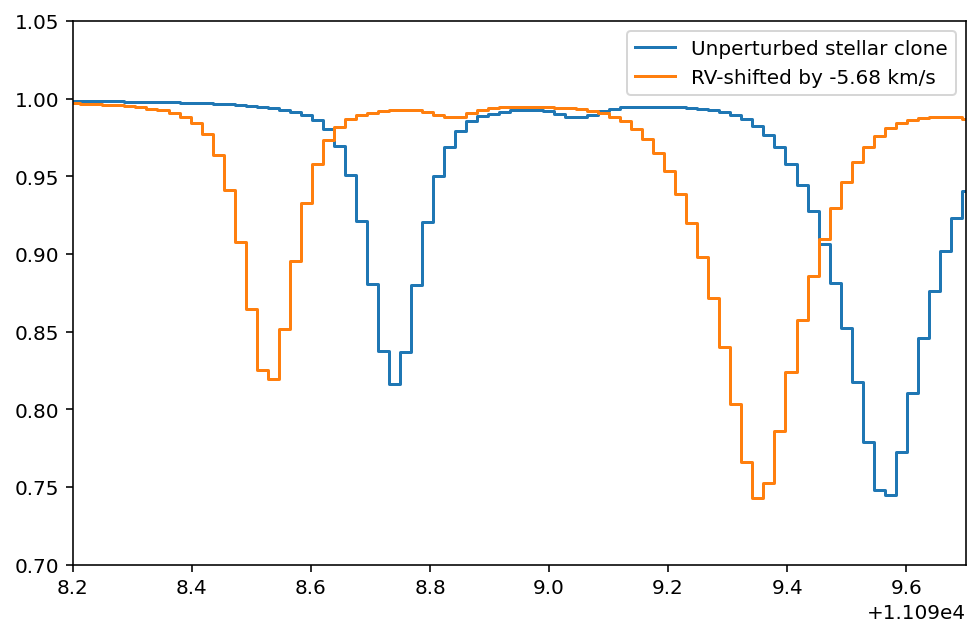

In [12]:
plt.figure(figsize=(8, 5))
plt.step(wavelength_grid, y0, label='Unperturbed stellar clone')
plt.step(wavelength_grid, y1, label=f'RV-shifted by {RV:0.2f} km/s')
plt.xlim(11_098.2, 11_099.7); plt.ylim(0.7, 1.05)
plt.legend();

Neat! Notice how the **pixel coordinates** stay in the same place, but the **line-center positions** change the fluxes evaluated at those coordinates.  The spectrum is not merely a translation of coordinates, its a re-evaluation of the coordinates with new line center positions.  This design choice ensures that the radial velocity is "auto-differentiable". 

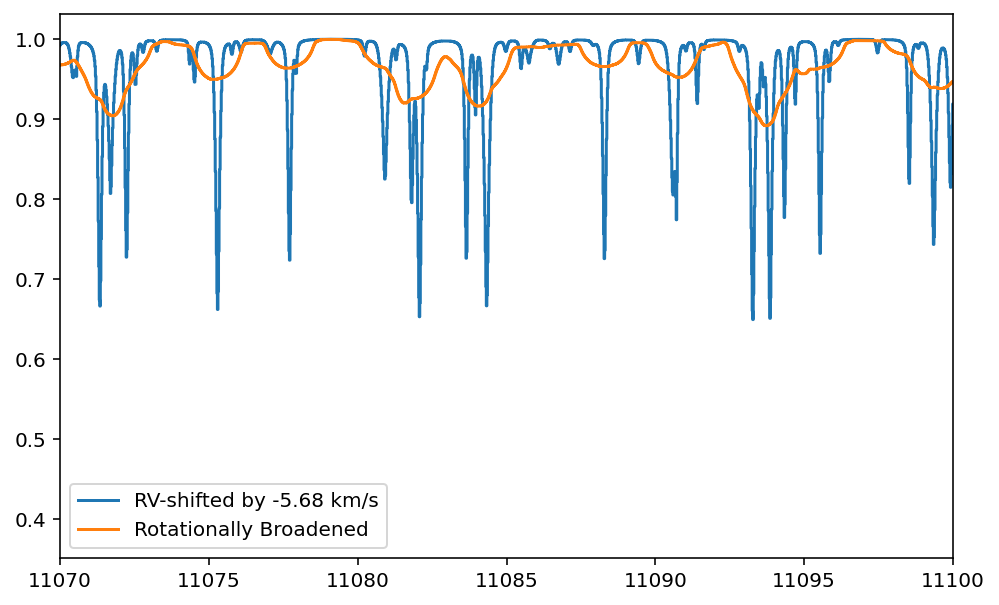

In [13]:
plt.figure(figsize=(8, 5))
plt.step(wavelength_grid, y1, label=f'RV-shifted by {RV:0.2f} km/s')
plt.step(wavelength_grid, y2, label=f'Rotationally Broadened ')
plt.xlim(11_070, 11_100)
plt.legend();

Voilá! We successfully modulated the cloned spectrum with both rotational broadening and radial_velocity.  We have not yet shown the full power of this technique: through the ["magic"](https://en.wikipedia.org/wiki/Scare_quotes) of [autodiff](https://en.wikipedia.org/wiki/Automatic_differentiation), these physically interpretable values can get updated simultaneously as the line strengths themselves are all perturbed.  We will see this tuning in the next step.